<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 5px; height: 70px">

# Optimising Hospital Bed Occupancy through Machine Learning
**DSI-41 Group FWSG**: Muhammad Faaiz Khan, Sharifah Nurulhuda, Tan Wei Chiong, Gabriel Tan

### 02_01 Data Cleaning and Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df =  pd.read_csv('../datasets/df_bor.csv')

In [3]:
# Reformatting the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])
# Setting date as the index
df = df.set_index('date')
df.head()

,year,nuh,total_rainfall,wet_bulb_temperature,dengue,urti,diarrhea,injuries,day,month,is_holiday
date,,,,,,,,,,,
2018-01-01,2018,73.5,32.2,25.2,12.0,3158.0,580.0,28.0,Mon,Jan,1
2018-01-02,2018,78.4,0.8,25.8,12.0,3158.0,580.0,28.0,Tue,Jan,0
2018-01-03,2018,83.1,2.0,26.5,12.0,3158.0,580.0,28.0,Wed,Jan,0
2018-01-04,2018,82.6,0.2,25.6,12.0,3158.0,580.0,28.0,Thu,Jan,0
2018-01-05,2018,79.8,1.0,25.4,12.0,3158.0,580.0,28.0,Fri,Jan,0


#### Exploring bed occupancy rate: Line Plot

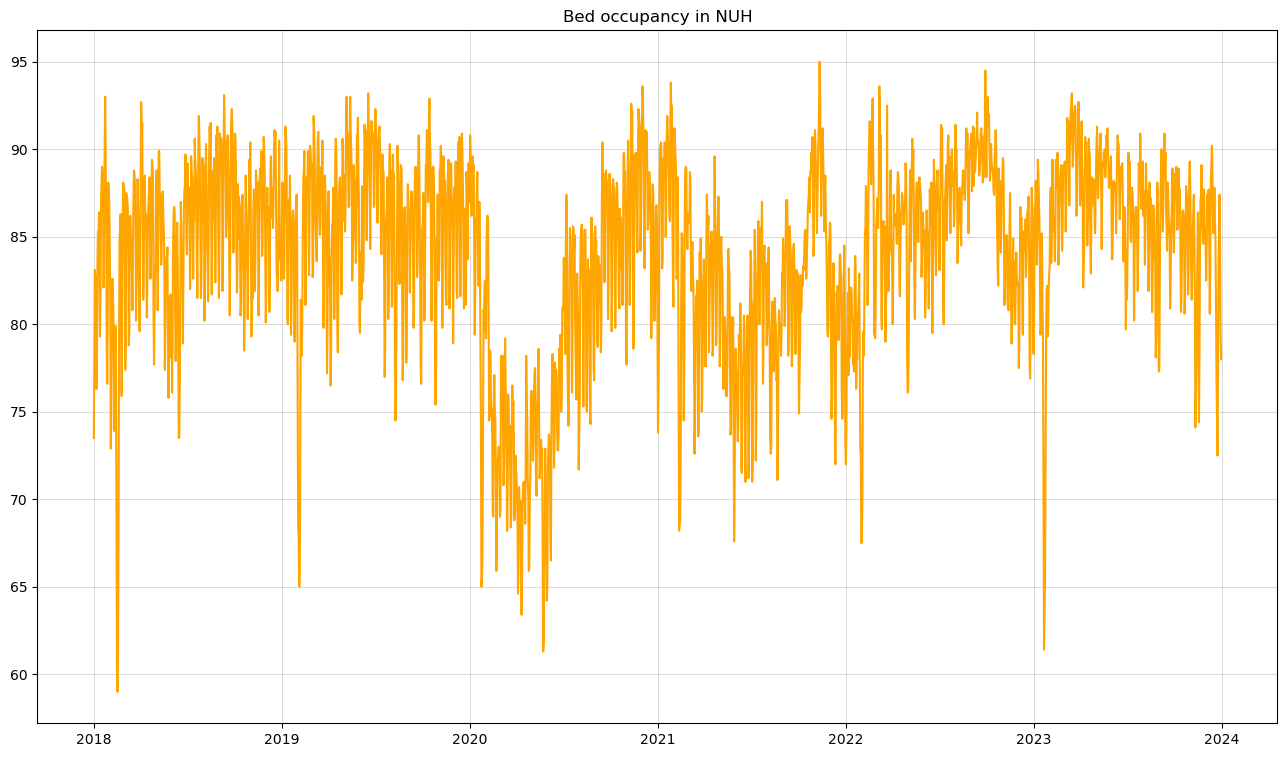

In [4]:
# Creating line plot
plt.figure(figsize = (16,9))
plt.plot(df['nuh'],
         c = 'orange')
plt.title("Bed occupancy in NUH")# Create a grid in the background
plt.grid(True, linewidth = 0.5, linestyle = '-', c = 'black', alpha = 0.2)

We observe from the line plot above that a large dip occurs in 2020, which coincides with the government's response to COVID-19, such as the Circuit Breaker and nationwide coordination efforts among hospitals to contain the pandemic. The datapoints between 2020 to 2021 will likely have an averse effect on our modeling for post-Covid predictions, thus we shall remove points within this period and use only datapoints within 2022-2023.

#### Box plot
Below, we plot the box plots of features within the dataset.

/Users/hudalhabsyi/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
/Users/hudalhabsyi/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
/Users/hudalhabsyi/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

[Text(0.5, 1.0, 'Distribution of Acute Diarrhea cases'),
 Text(0, 0.5, 'Number of cases')]

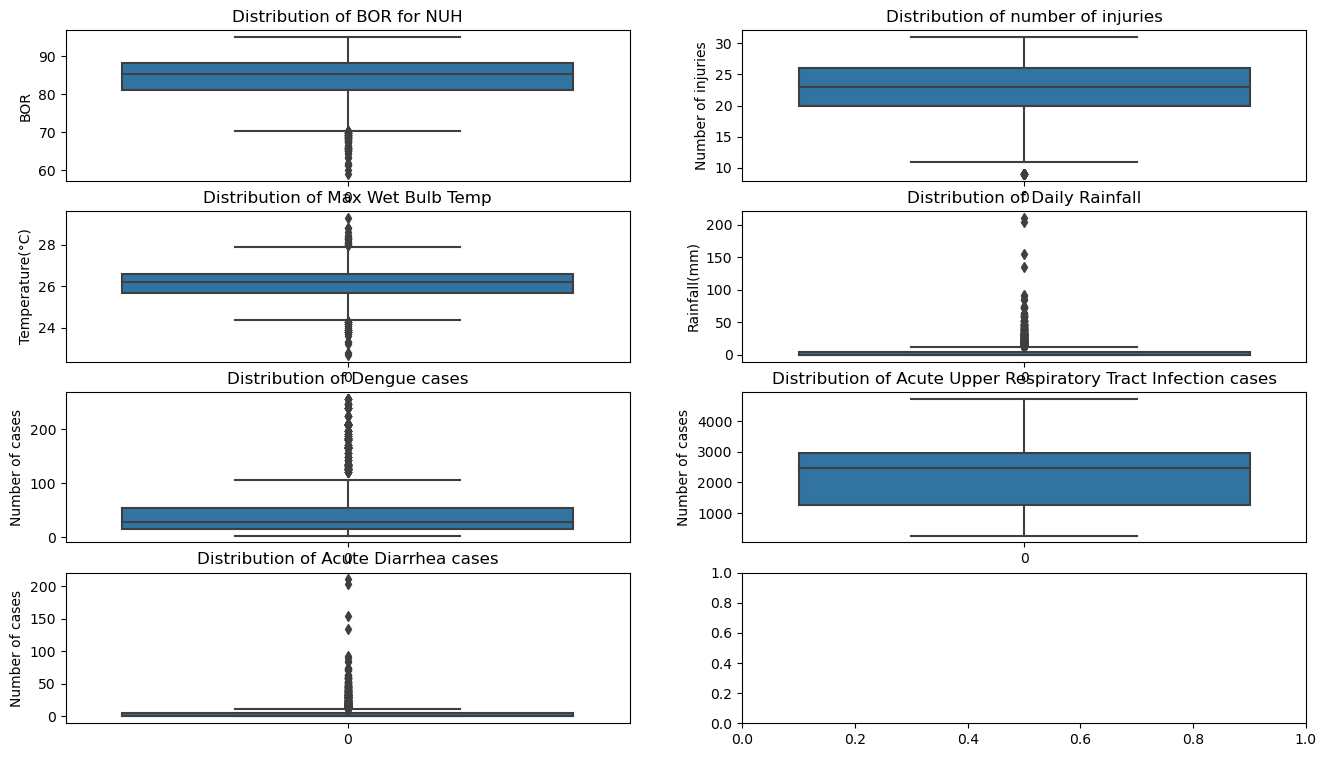

In [5]:
fig, axes = plt.subplots(4, 2, figsize=(16,9)) 

box1 = sns.boxplot(data=df['nuh'], ax = axes[0][0])
box1.set(title="Distribution of BOR for NUH",
         xlabel = 'NUH',
         ylabel='BOR')

box2 = sns.boxplot(data=df['injuries'], ax = axes[0][1])
box2.set(title="Distribution of number of injuries",
         ylabel='Number of injuries')

box3 = sns.boxplot(data=df['wet_bulb_temperature'], ax = axes[1][0])
box3.set(title="Distribution of Max Wet Bulb Temp",
         ylabel='Temperature(°C)')

box4 = sns.boxplot(data=df['total_rainfall'], ax = axes[1][1])
box4.set(title="Distribution of Daily Rainfall",
         ylabel='Rainfall(mm)')

box5 = sns.boxplot(data=df['dengue'], ax = axes[2][0])
box5.set(title="Distribution of Dengue cases",
         ylabel='Number of cases')

box6 = sns.boxplot(data=df['urti'], ax = axes[2][1])
box6.set(title="Distribution of Acute Upper Respiratory Tract Infection cases",
         ylabel='Number of cases')

box7 = sns.boxplot(data=df['total_rainfall'], ax = axes[3][0])
box7.set(title="Distribution of Acute Diarrhea cases",
         ylabel='Number of cases')

In [6]:
# To better understand the spread of the datapoints, we also generate the standard deviations below.
df.select_dtypes(include=['int', 'float']).std()

year                      1.707859
nuh                       5.627448
total_rainfall           13.786371
wet_bulb_temperature      0.736929
dengue                   50.676669
urti                    943.509753
diarrhea                143.114324
injuries                  4.523733
is_holiday                0.187606
dtype: float64

The boxplots above show the presence of outlier values beyond the 25th and 75th percentile. However, the values for these outliers do not seem to indicate any measurement/entry errors as they do not deviate significantly from the expected values of each feature. We will retain these outliers for our models to capture the natural variations within the dataset.

#### Correlation heat map and pairplot

Below, we shall plot the correlation heat map to identify any features with strong correlation with our target features, i.e. the bed availability for each hospital.

<Axes: >

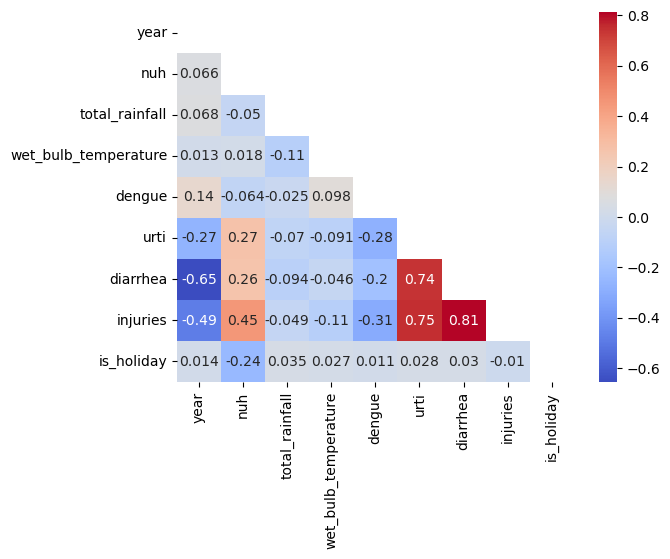

In [7]:
# Plotting correlation heat map for the data
numeric_columns = df.select_dtypes(include=['int', 'float'])
corr = numeric_columns.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, annot=True, cmap='coolwarm')

/Users/hudalhabsyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/hudalhabsyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/hudalhabsyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/hudalhabsyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

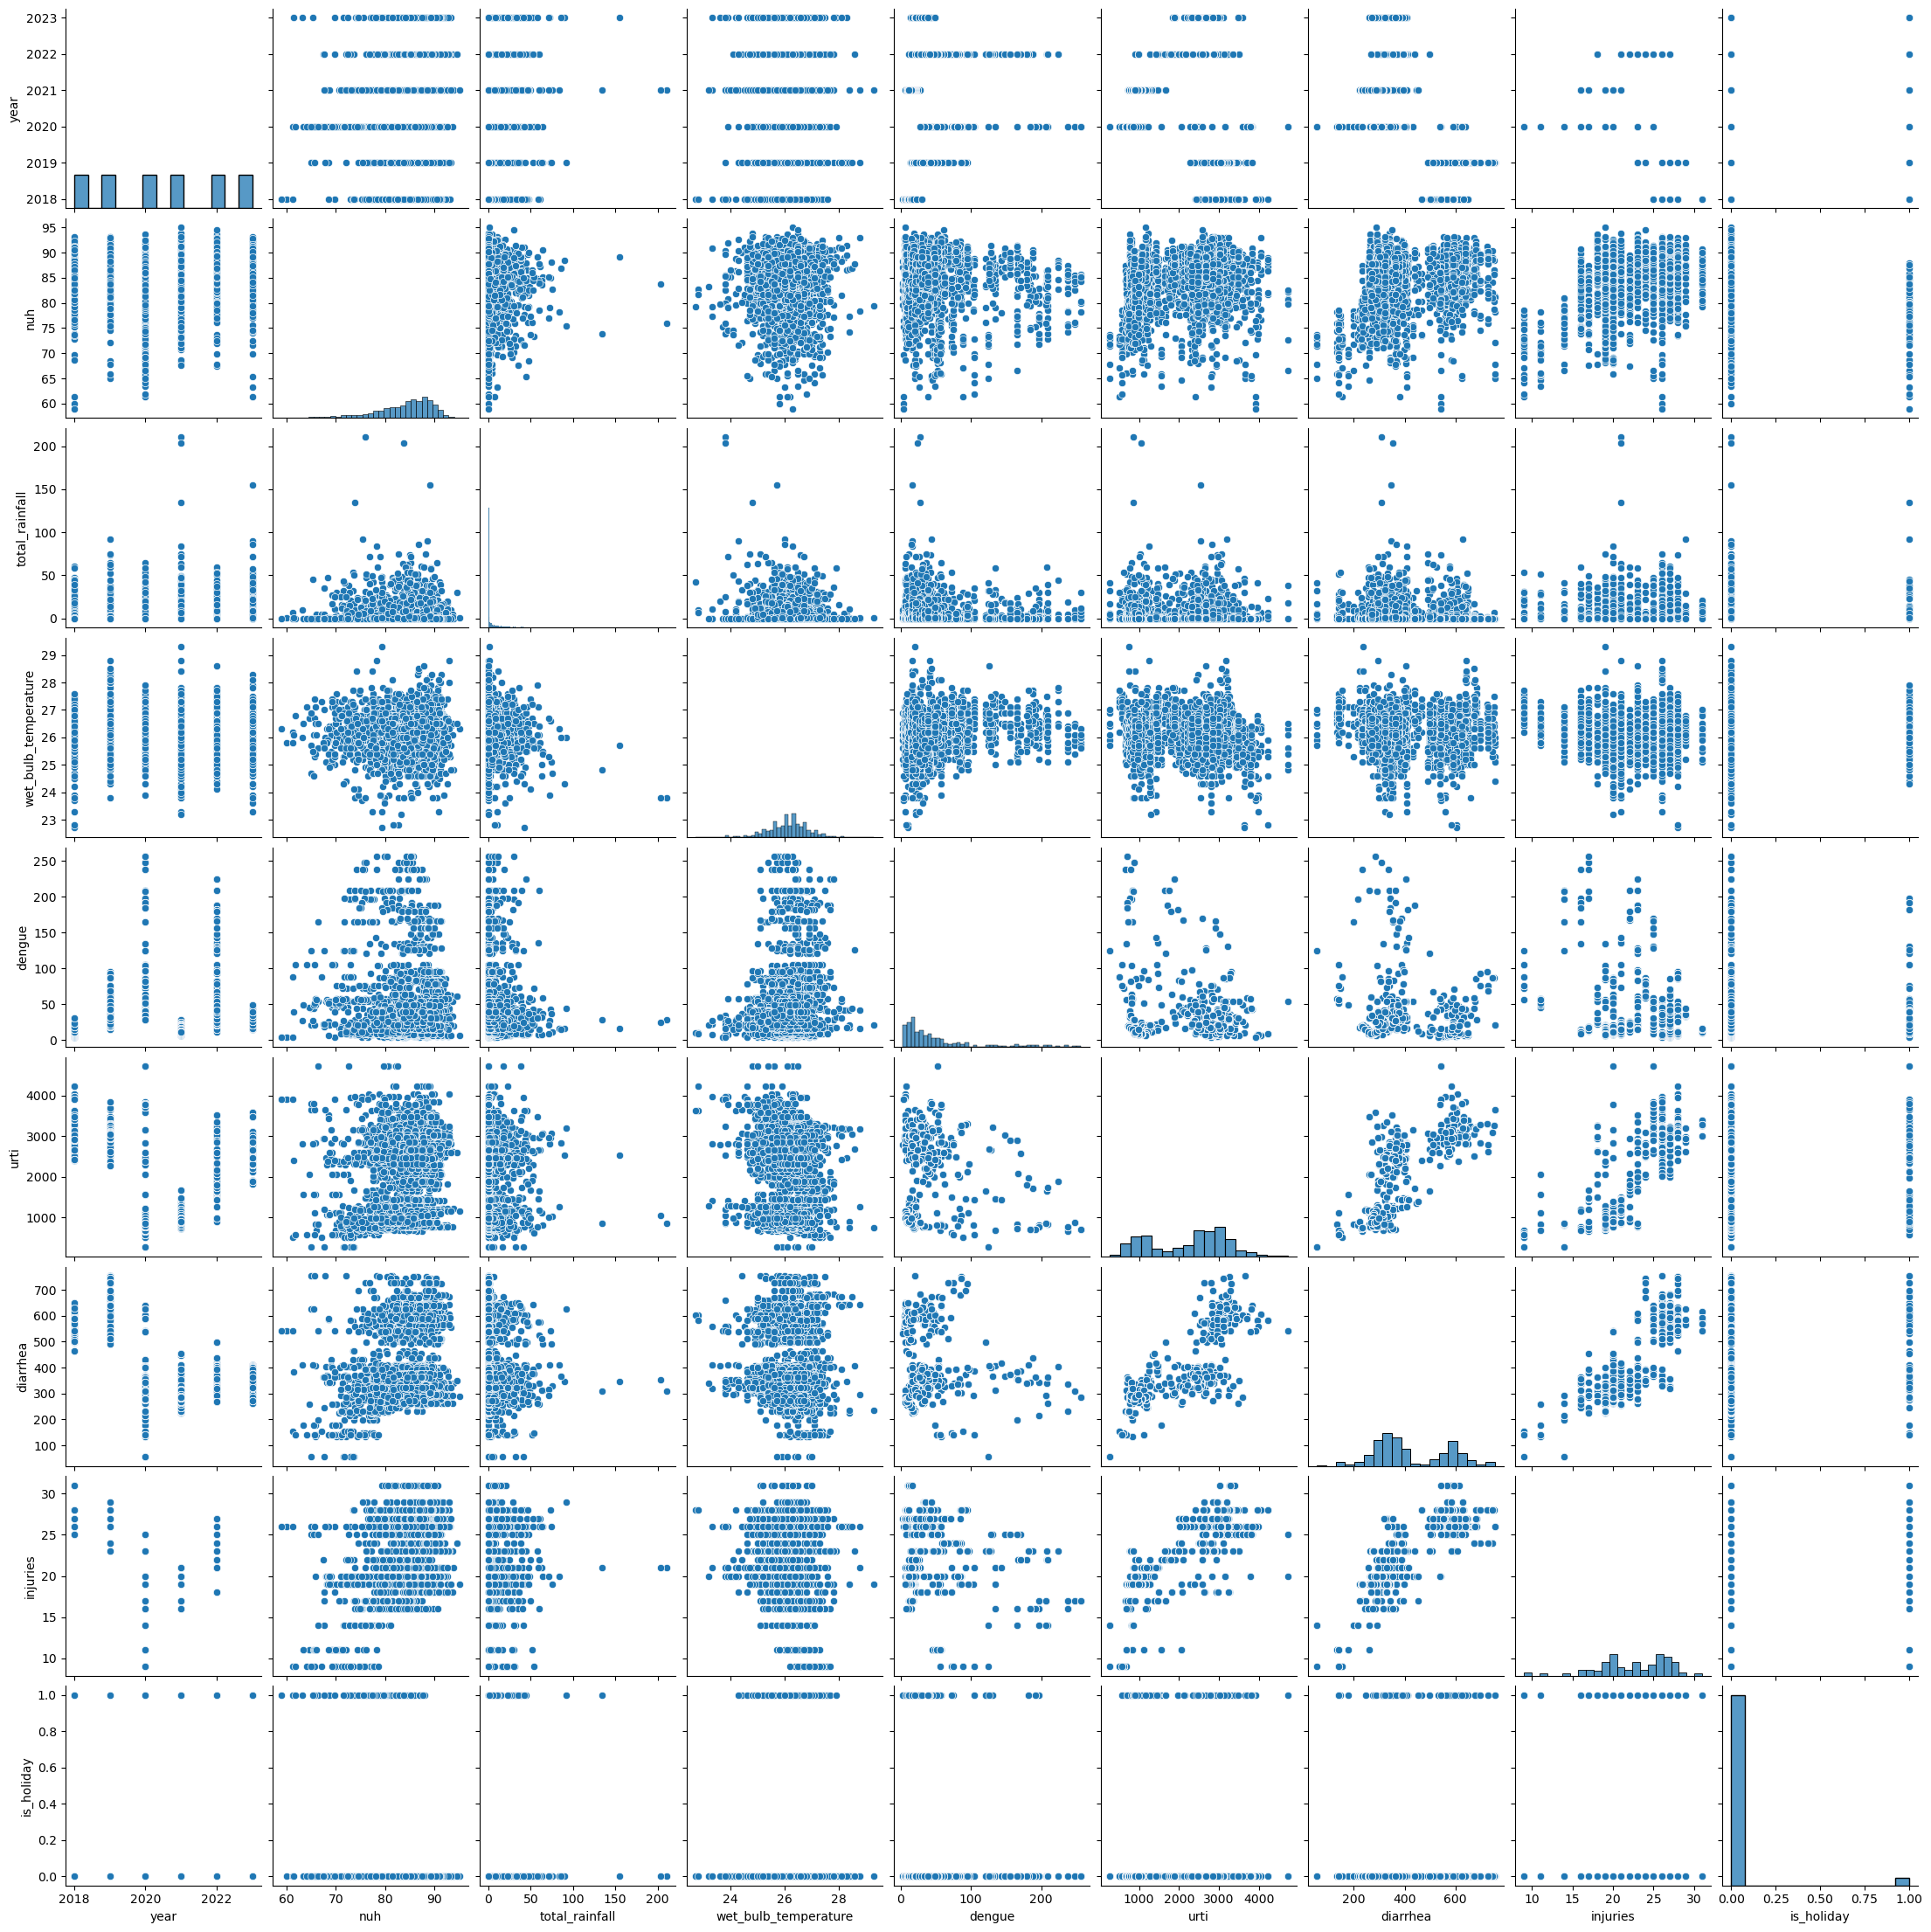

In [8]:
# Plotting pairplot for the data to visually glance collinearity of the features.
sns.pairplot(df)

Based on the above correlation heat map and pairplot:

`injuries` displays relatively high correlation with other features such as `diarrhea` and `urti`, suggesting multicollinearity if included. Given that we are also missing values for `injuries` beyond 2022 and that we are only going to model BOR for 2022-2023, we will be dropping the `injuries` variable from analysis.

##### A summary of the datapoints to be dropped:
- 2020 to 2021 period
- the variable `injuries`

In [9]:
# Filtering out the above datapoints from our model
df = df[df.index.year.isin([2022,2023])]
df = df.drop(columns=['injuries'])

In [10]:
# Checking first and last entry of updated dataframe
print(df.head(1))
print(df.tail(1))

            year   nuh  total_rainfall  wet_bulb_temperature  dengue   urti  \
date                                                                          
2022-01-01  2022  72.0            25.2                  26.0    11.0  904.0   

            diarrhea  day month  is_holiday  
date                                         
2022-01-01     287.0  Sat   Jan           1  
            year   nuh  total_rainfall  wet_bulb_temperature  dengue    urti  \
date                                                                           
2023-12-31  2023  78.0            33.4                  25.6    39.0  2467.0   

            diarrhea  day month  is_holiday  
date                                         
2023-12-31     324.0  Sun   Dec           0  


#### Feature engineering using PolynomialFeatures

Given the generally low correlation scores of features with `nuh` seen earlier, we will attempt to generate more predictive features using PolynomialFeatures, which may produce interaction terms with better predictive power.

In [11]:
num_feats = ['wet_bulb_temperature', 'total_rainfall', 'dengue', 'urti', 'diarrhea']
cat_feats = ['is_holiday', 'month', 'day']
target = ['nuh']

In [12]:
numeric_transformer = Pipeline(
    steps=[('poly', PolynomialFeatures(degree=2,include_bias=False))]
)

cat_transformer = Pipeline(
    steps=[('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))]
)

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, num_feats),
                    ('cat', cat_transformer, cat_feats)]
)

In [13]:
X = df.drop(columns=target)

In [14]:
X_poly = preprocessor.fit_transform(X)

In [15]:
poly_features = pd.DataFrame(X_poly, columns=preprocessor.get_feature_names_out(X.columns))

In [16]:
poly_features.head()

,num__wet_bulb_temperature,num__total_rainfall,num__dengue,num__urti,num__diarrhea,num__wet_bulb_temperature^2,num__wet_bulb_temperature total_rainfall,num__wet_bulb_temperature dengue,num__wet_bulb_temperature urti,num__wet_bulb_temperature diarrhea,...,cat__month_May,cat__month_Nov,cat__month_Oct,cat__month_Sep,cat__day_Mon,cat__day_Sat,cat__day_Sun,cat__day_Thu,cat__day_Tue,cat__day_Wed
0,26.0,25.2,11.0,904.0,287.0,676.00,655.20,286.0,23504.0,7462.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,24.1,50.0,15.0,977.0,297.0,580.81,1205.00,361.5,23545.7,7157.7,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,25.6,6.0,15.0,977.0,297.0,655.36,153.60,384.0,25011.2,7603.2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,25.8,4.8,15.0,977.0,297.0,665.64,123.84,387.0,25206.6,7662.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,26.3,1.0,15.0,977.0,297.0,691.69,26.30,394.5,25695.1,7811.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
poly_features.shape

(730, 38)

In [18]:
poly_features_csv = pd.concat([df.reset_index(), poly_features], axis=1)

In [19]:
poly_features_csv.head()

,date,year,nuh,total_rainfall,wet_bulb_temperature,dengue,urti,diarrhea,day,month,...,cat__month_May,cat__month_Nov,cat__month_Oct,cat__month_Sep,cat__day_Mon,cat__day_Sat,cat__day_Sun,cat__day_Thu,cat__day_Tue,cat__day_Wed
0,2022-01-01,2022,72.0,25.2,26.0,11.0,904.0,287.0,Sat,Jan,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2022-01-02,2022,73.7,50.0,24.1,15.0,977.0,297.0,Sun,Jan,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2022-01-03,2022,78.7,6.0,25.6,15.0,977.0,297.0,Mon,Jan,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-04,2022,79.1,4.8,25.8,15.0,977.0,297.0,Tue,Jan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2022-01-05,2022,81.8,1.0,26.3,15.0,977.0,297.0,Wed,Jan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
poly_features_csv.drop(columns='date',inplace=True)
poly_features_csv.drop(columns=cat_feats,inplace=True)

In [21]:
poly_features_csv.columns

Index(['year', 'nuh', 'total_rainfall', 'wet_bulb_temperature', 'dengue',
       'urti', 'diarrhea', 'num__wet_bulb_temperature', 'num__total_rainfall',
       'num__dengue', 'num__urti', 'num__diarrhea',
       'num__wet_bulb_temperature^2',
       'num__wet_bulb_temperature total_rainfall',
       'num__wet_bulb_temperature dengue', 'num__wet_bulb_temperature urti',
       'num__wet_bulb_temperature diarrhea', 'num__total_rainfall^2',
       'num__total_rainfall dengue', 'num__total_rainfall urti',
       'num__total_rainfall diarrhea', 'num__dengue^2', 'num__dengue urti',
       'num__dengue diarrhea', 'num__urti^2', 'num__urti diarrhea',
       'num__diarrhea^2', 'cat__is_holiday_1', 'cat__month_Aug',
       'cat__month_Dec', 'cat__month_Feb', 'cat__month_Jan', 'cat__month_Jul',
       'cat__month_Jun', 'cat__month_Mar', 'cat__month_May', 'cat__month_Nov',
       'cat__month_Oct', 'cat__month_Sep', 'cat__day_Mon', 'cat__day_Sat',
       'cat__day_Sun', 'cat__day_Thu', 'cat__day_Tue

In [22]:
poly_features_csv.shape

(730, 45)

### Exporting the data for modeling

- The following dataframe with polynomial features will be used for our subsequent regression modeling:

In [23]:
# Export the DataFrame to a CSV file
poly_features_csv.to_csv('../datasets/for_regression.csv', index=False)

- Separately, the following dataframe (without polynomial features) will be used for time-series prediction modeling:

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2022-01-01 to 2023-12-31
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  730 non-null    int64  
 1   nuh                   730 non-null    float64
 2   total_rainfall        730 non-null    float64
 3   wet_bulb_temperature  730 non-null    float64
 4   dengue                730 non-null    float64
 5   urti                  730 non-null    float64
 6   diarrhea              730 non-null    float64
 7   day                   730 non-null    object 
 8   month                 730 non-null    object 
 9   is_holiday            730 non-null    int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 62.7+ KB


In [25]:
# Perform one-hot encoding for time-series modeling:
dummy_variables = pd.get_dummies(df[['day','month']], drop_first=True)

# Concatenate the dummy variables with the original DataFrame
for_regression_csv = pd.concat([df, dummy_variables], axis=1)

# Drop the original columns for which dummy variables were created
for_regression_csv = for_regression_csv.drop(columns=['day','month'])

In [26]:
# Export the DataFrame to a CSV file
for_regression_csv.to_csv('../datasets/for_timeseries.csv', index=True)